[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building CMNDs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [39]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the package

Import **multimin** and other required libraries:

In [40]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [41]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

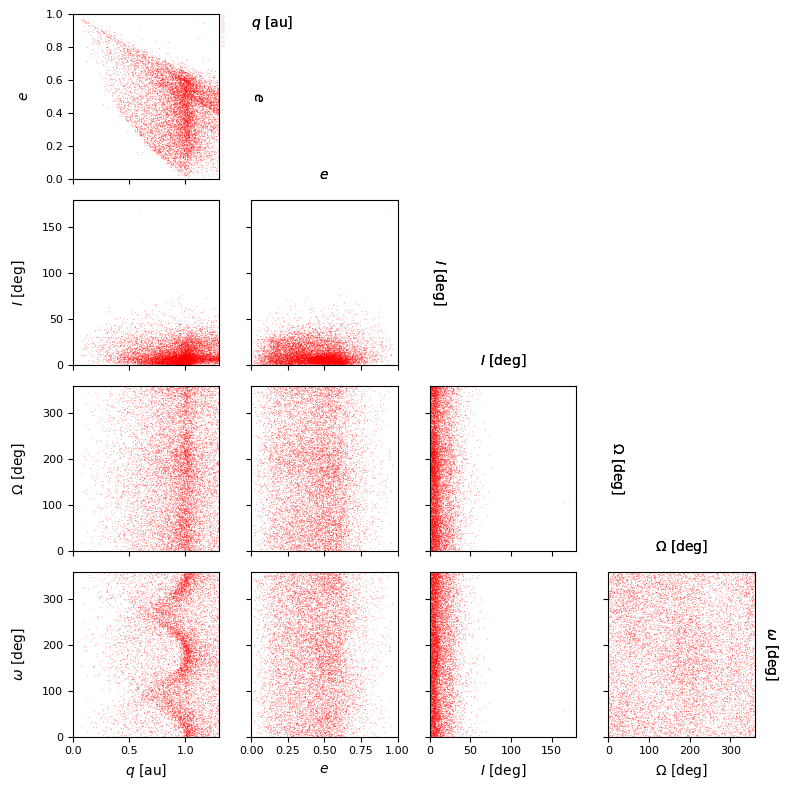

In [42]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.DensityPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

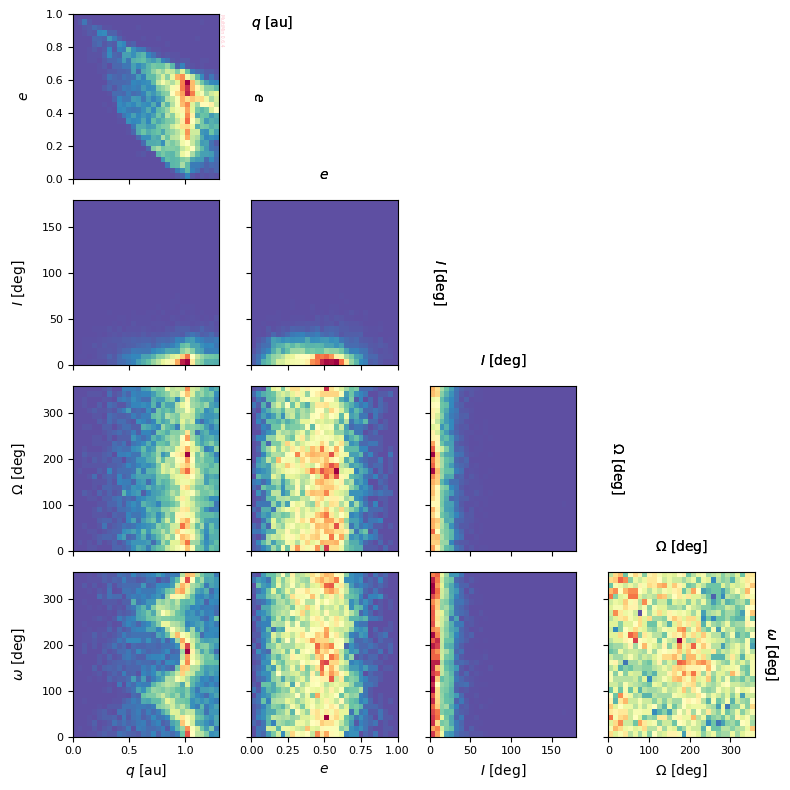

In [43]:
G=mn.DensityPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [44]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

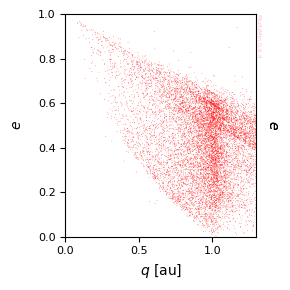

In [45]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')



Now we will proceed to fit the data against a singled truncated distribution:

In [46]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(data_neas_qe, advance=0)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 288.301 ms
-log(L)/N = -0.5479490390258412


And check the fit result:

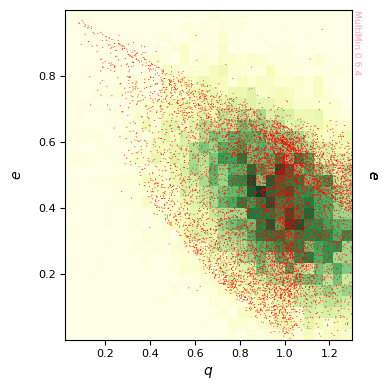

In [47]:
props=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qe_1.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [48]:
F_qe_1.cmnd.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.976231,0.413567,0.265331,0.18865,-0.428872


We can do it better increasing the number of normals:

In [59]:
t = mn.Util.el_time(0)
F = mn.FitCMND(ngauss=5, nvars=2, domain=[[0,1.3], [0, 1]])
F.fit_data(data_neas_qe)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 28.1327 s
-log(L)/N = -0.7320814840687974


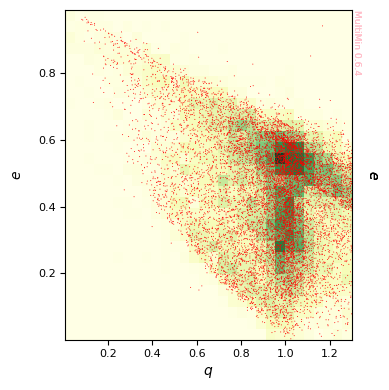

In [60]:
props=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [51]:
neas_sample = F.cmnd.rvs(len(data_neas_qe))

And plot it:

Text(0.5, 1.0, 'Original data')

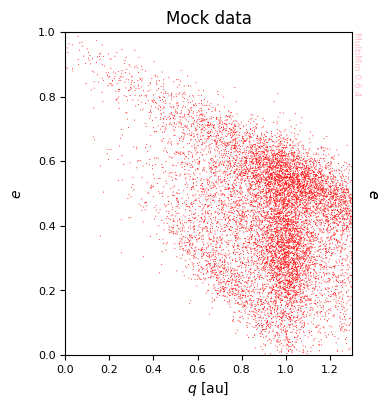

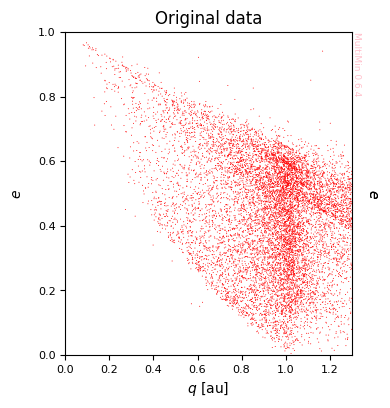

In [52]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.DensityPlot(properties,figsize=4)
G.scatter_plot(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.DensityPlot(properties,figsize=4)
scatter=G.scatter_plot(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [53]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.cmnd.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
2,0.348373,0.932905,0.359591,0.263902,0.159202,-0.668072
4,0.275339,1.279992,0.447813,0.484433,0.195120,-0.962498
3,0.198412,1.003833,0.333035,0.055722,0.148362,-0.069287
5,0.098658,1.011274,0.559821,0.133980,0.053356,-0.101481
1,0.079218,0.752261,0.219085,0.164890,0.115706,-0.926253


In [54]:
function, cmnd = F.cmnd.get_function(properties=properties)

import numpy as np
from multimin import tnmd

def cmnd(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.752261
    mu1_e = 0.219085
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.027189, -0.017672], [-0.017672, 0.013388]]
    Z1 = 0.97085
    n1 = tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.932905
    mu2_e = 0.359591
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.069644, -0.028068], [-0.028068, 0.025345]]
    Z2 = 0.913754
    n2 = tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 1.003833
    mu3_e = 0.333035
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.003105, -0.000573], [-0.000573, 0.022011]]
    Z3 = 0.987604
    n3 = tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.279992
    mu4_e = 0.447813
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.234675, -0.090978], [-0.090978, 0.038072]]
    Z4 = 0.511988
    n4 = tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.011274
    mu5_e = 0.559821
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.017951, -0.000725], [-0.000725, 0.002847]]
    Z5 = 0.984419
    n

### Fitting other pair of properties

Fitting $q$ and $I$:

-log(L)/N = 3.488469534095998


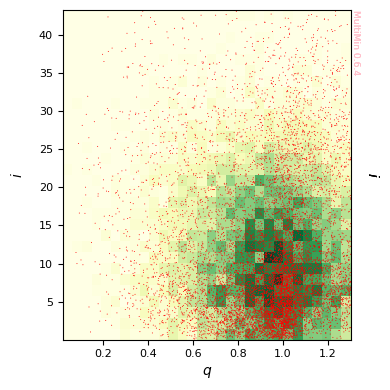

In [55]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(data_neas_qi, advance=0)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

props=["q","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qi_1.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

-log(L)/N = 3.323113134754986


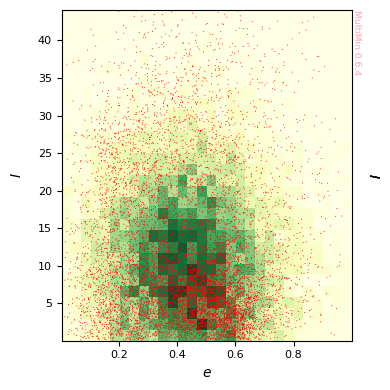

In [56]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(data_neas_ei, advance=0)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

props=["e","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [57]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

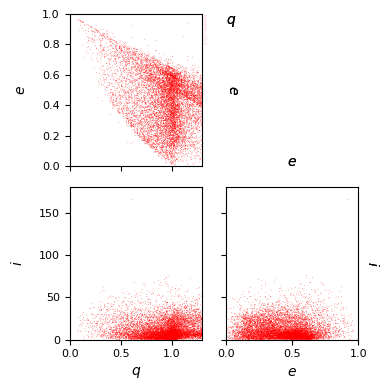

In [58]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.DensityPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.scatter_plot(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Iterations:
Iter 0:
	Vars: [0.38, 0.5, 0.0028, -2.5, -2.2, -7.5, 1.4, 0.83, 1.1]
	LogL/N: 689.7278103690505
Iter 1:
	Vars: [0.39, 0.51, 0.05, -2.5, -2.2, -7.5, 1.2, 1, 1.1]
	LogL/N: 689.2571386813523
Iter 2:
	Vars: [0.39, 0.51, 0.054, -2.5, -2.2, -7.5, 1.7, 0.59, 1.1]
	LogL/N: 689.1408748288602
Iter 3:
	Vars: [0.37, 0.49, 0.077, -2.5, -2.2, -7.5, 1.6, 0.64, 1.1]
	LogL/N: 688.820061609371
Iter 4:
	Vars: [0.37, 0.48, 0.07, -2.5, -2.2, -7.5, 1.5, 0.71, 1.1]
	LogL/N: 688.8962525841071
Iter 5:
	Vars: [0.36, 0.48, 0.067, -2.5, -2.2, -7.5, 1.4, 0.81, 1.1]
	LogL/N: 688.9263974404972
Iter 6:
	Vars: [0.35, 0.47, 0.064, -2.5, -2.2, -7.4, 1.5, 0.72, 1]
	LogL/N: 688.8105601198247
Iter 7:
	Vars: [0.32, 0.43, 0.062, -2.5, -2.2, -7.1, 1.9, 0.38, 0.94]
	LogL/N: 688.3460150096257
Iter 8:
	Vars: [0.27, 0.43, 0.063, -2.5, -2.2, -6.8, 2.2, 0.099, 0.84]
	LogL/N: 687.8962751612389
Iter 9:
	Vars: [0.27, 0.43, 0.063, -2.5, -2.2, -6.8, 2.3, 0.08, 0.83]
	LogL/N: 687.8427812710893
Iter 10:
	Vars: [0.21, 0.45, 0.0

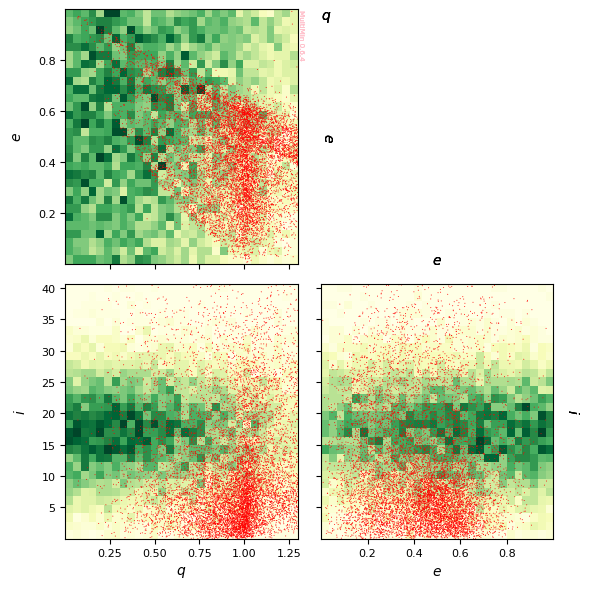

In [21]:
fit_qei = mn.FitCMND(ngauss=1, nvars=3, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(data_neas_qei, advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

props=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

Iterations:
Iter 0:
	Vars: [0.75, 0.42, 0.048, -3.9, -4, -5.2, -0.92, -0.054, -0.088]
	LogL/N: 674.052603071206
-log(L)/N = -2.3846430211355267


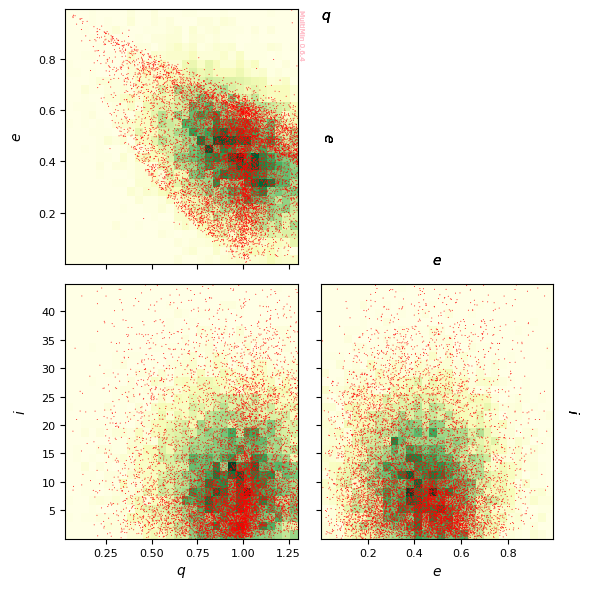

In [22]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.cmnd.mus[0, 0] + F_qi_1.cmnd.mus[0, 0]) / 2
mu_e = (F_qe_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 0]) / 2
mu_i = (F_qi_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 1]) / 2
sigma_q = (F_qe_1.cmnd.sigmas[0, 0] + F_qi_1.cmnd.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.cmnd.rhos[0, 0])
rho_qi = float(F_qi_1.cmnd.rhos[0, 0])
rho_ei = float(F_ei_1.cmnd.rhos[0, 0])

fit_qei = mn.FitCMND(ngauss=1, nvars=3, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(data_neas_qei, advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

props=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Iterations:
Iter 0:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.92, -0.054, -0.088, -0.92, -0.054, -0.088, -0.92, -0.054, -0.088, -0.92, -0.054, -0.088, -0.92, -0.054, -0.088]
	LogL/N: 3.0706716904118885
Iter 1:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.92, -0.054, -0.088, -0.92, -0.054, -0.088, -0.92, -0.054, -0.088, -0.92, -0.054, -0.088, -0.92, -0.054, -0.088]
	LogL/N: 3.0706701863121824
Iter 2:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, 0.97, 0.42, 8.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.92, -0.054, -0.088, -0.92, -0.054, -0.088, -0.92, -0.054, -0.088, -0.92, -0.054, 

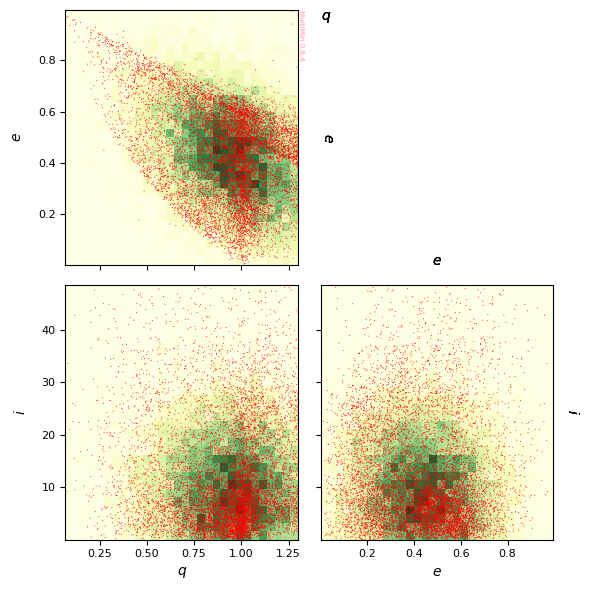

In [23]:
fit_qei = mn.FitCMND(ngauss=5, nvars=3, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(data_neas_qei, advance=True)
G=fit_qei.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the CMND is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the CMND in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [24]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **DensityPlot** (scatter on pairwise panels):

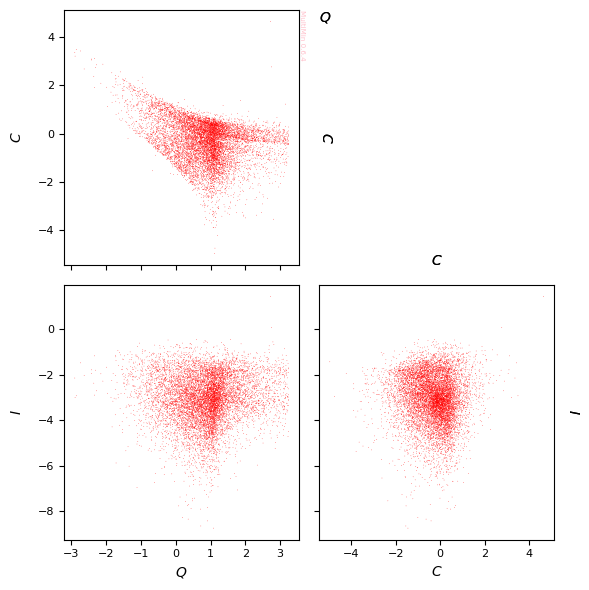

In [25]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.DensityPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

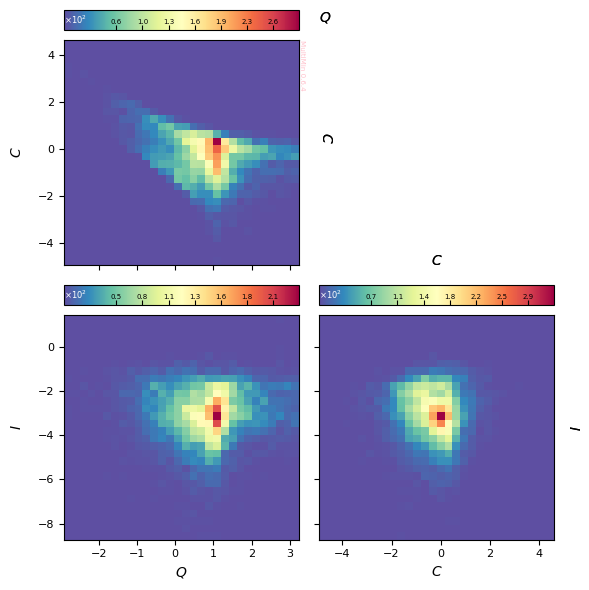

In [26]:
G=mn.DensityPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [27]:
F=mn.FitCMND(ngauss=1,nvars=3)

The fitter holds an initial CMND that will be optimized:

In [28]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.0, 0.0, 0.0]]
    Standard deviations (σ): [[1.0, 1.0, 1.0]]
    Correlation coefficients (ρ): [[0.0, 0.0, 0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


Run the minimization:

In [29]:
t = mn.Util.el_time(0)
F.fit_data(udata,verbose=False,advance=1)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Iterations:
Iter 0:
	Vars: [2.3, 1.4, -2, -1.9, -1.7, -1.8, 1.4, 1.1, 1.1]
	LogL/N: 5.26659658146592
Iter 1:
	Vars: [1.8, 0.53, -2.5, -1.8, -1.8, -1.9, 1.1, 1, 0.81]
	LogL/N: 4.729656565221321
Iter 2:
	Vars: [0.82, -0.37, -3.1, -2.2, -2.2, -2, -0.04, 0.24, 0.51]
	LogL/N: 4.100560023514606
Iter 3:
	Vars: [0.88, -0.35, -3, -2.4, -2.4, -2.1, -0.63, 0.062, -0.085]
	LogL/N: 3.955752092238605
Iter 4:
	Vars: [0.87, -0.33, -3, -2.4, -2.4, -2.1, -0.65, 0.072, -0.13]
	LogL/N: 3.9547925736672114
Iter 5:
	Vars: [0.87, -0.33, -3.1, -2.4, -2.4, -2.1, -0.65, 0.072, -0.14]
	LogL/N: 3.954583389979998
Iter 6:
	Vars: [0.87, -0.33, -3.1, -2.4, -2.4, -2.1, -0.65, 0.072, -0.14]
	LogL/N: 3.954583389979998
Elapsed time since last call: 451.03 ms
-log(L)/N = 3.954583389979998


Inspect the fitted CMND:

In [30]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8683673984547176, -0.32813697064905406, -3.050365236264645]]
    Standard deviations (σ): [[0.8516842441842544, 0.8573595804870513, 1.0699122420321043]]
    Correlation coefficients (ρ): [[-0.31433176937157514, 0.035930649281583404, -0.06753991267361903]]

    Covariant matrices (Σ): 
        [[[0.7253660517917047, -0.22952494681636826, 0.03274099209637407], [-0.22952494681636826, 0.7350654502529326, -0.061954328867588775], [0.03274099209637407, -0.061954328867588775, 1.1447122056501642]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8683673984547176, -0.32813697064905406, -3.050365236264645, 0.7253660517917047, -0.22952494681636826, 0.03274099209637407, 0.7350654502529326, -0.061954328867588775, 1.1447122056501642]
        With std. and

Plot the fit result (fitted sample + data scatter):

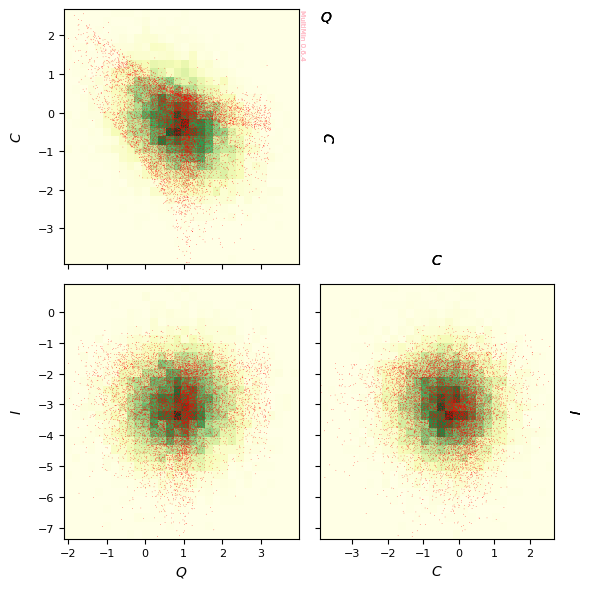

In [31]:
props=["Q","C","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
G=F.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [32]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [33]:
F=mn.FitCMND(f"gallery/{figprefix}_fit-single.pkl")
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8683673984547176, -0.32813697064905406, -3.050365236264645]]
    Standard deviations (σ): [[0.8516842441842544, 0.8573595804870513, 1.0699122420321043]]
    Correlation coefficients (ρ): [[-0.31433176937157514, 0.035930649281583404, -0.06753991267361903]]

    Covariant matrices (Σ): 
        [[[0.7253660517917047, -0.22952494681636826, 0.03274099209637407], [-0.22952494681636826, 0.7350654502529326, -0.061954328867588775], [0.03274099209637407, -0.061954328867588775, 1.1447122056501642]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8683673984547176, -0.32813697064905406, -3.050365236264645, 0.7253660517917047, -0.22952494681636826, 0.03274099209637407, 0.7350654502529326, -0.061954328867588775, 1.1447122056501642]
        With std. and

Fit with two Gaussian components for a better likelihood:

Iterations:
Iter 0:
	Vars: [0, 0, 2.7, 1.4, -2.1, 1.8, 0.52, -2.3, -1.2, -1.4, -1.6, -2.1, -2, -2, 1.5, 1.2, 1.2, 1.3, 1.3, 0.88]
	LogL/N: 4.940678988831743
Iter 5:
	Vars: [-1.4, -0.011, 0.23, 0.31, -3.4, 1.1, -0.57, -2.9, -2.5, -2.6, -1.9, -2.5, -2.5, -2.3, -1.4, -0.78, 0.54, 0.12, 0.25, -0.17]
	LogL/N: 3.8676243682397793
Iter 8:
	Vars: [-1.3, -0.011, 0.34, 0.33, -3.5, 1.1, -0.6, -2.9, -2.4, -2.7, -1.9, -2.5, -2.5, -2.3, -1.6, -0.85, 0.72, 0.11, 0.22, -0.074]
	LogL/N: 3.865175769484772
Elapsed time since last call: 719.845 ms
-log(L)/N = 3.865175769484772
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.30395749520002807, 0.696042504799972]
    Number of variables: 3
    Averages (μ): [[0.33608089670123825, 0.33394739185862704, -3.5227827155903038], [1.0872850899419768, -0.6028277155061121, -2.8549808016878235]]
    Standard deviations (σ): [[0.8038419059358564, 0.6384272712621779, 1.2866536186934736], [0.7702644491430367, 0.7791197833744

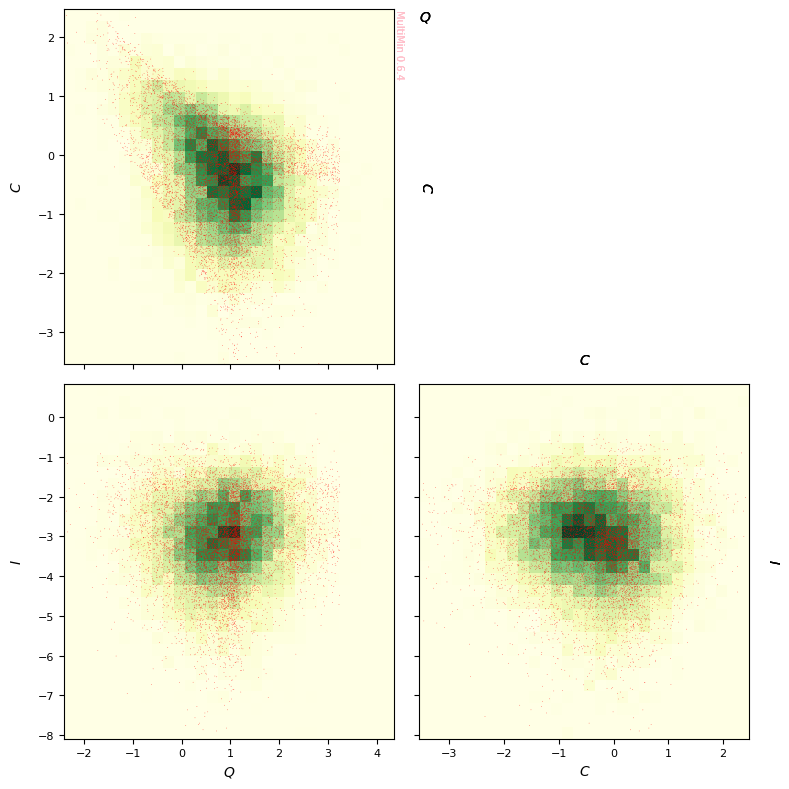

In [34]:
F=mn.FitCMND(ngauss=2,nvars=3)

mn.Util.el_time(0)
F.fit_data(udata,advance=5)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)

G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.7, 1.4, -2.1, 1.8, 0.52, -2.3, -1.3, -1.4, -1.6, -2.1, -2.1, -2, 1.5, 1.2, 1.1, 1.3, 1.3, 0.87]
	LogL/N: 4.939411156230602
Iter 5:
	Vars: [-0.53, 2.2, 0.23, 0.3, -3.4, 1.1, -0.57, -2.9, -2.5, -2.6, -1.9, -2.5, -2.5, -2.3, -1.4, -0.78, 0.55, 0.12, 0.25, -0.17]
	LogL/N: 3.8676057042259955
Iter 8:
	Vars: [-0.43, 2.2, 0.32, 0.33, -3.5, 1.1, -0.6, -2.9, -2.4, -2.7, -1.9, -2.5, -2.5, -2.3, -1.6, -0.86, 0.72, 0.11, 0.22, -0.087]
	LogL/N: 3.8652757259429738
Elapsed time since last call: 847.99 ms
-log(L)/N = 3.8652757259429738
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.3044056928857596, 0.6955943071142404]
    Number of variables: 3
    Averages (μ): [[0.32298051050246895, 0.3340052040740156, -3.5155189934242577], [1.0901615044852635, -0.6010011168177186, -2.8564215327214995]]
    Standard deviations (σ): [[0.8024472305809248, 0.641263413722271, 1.289403258145204], [0.7682823386276441, 0.77983078083669

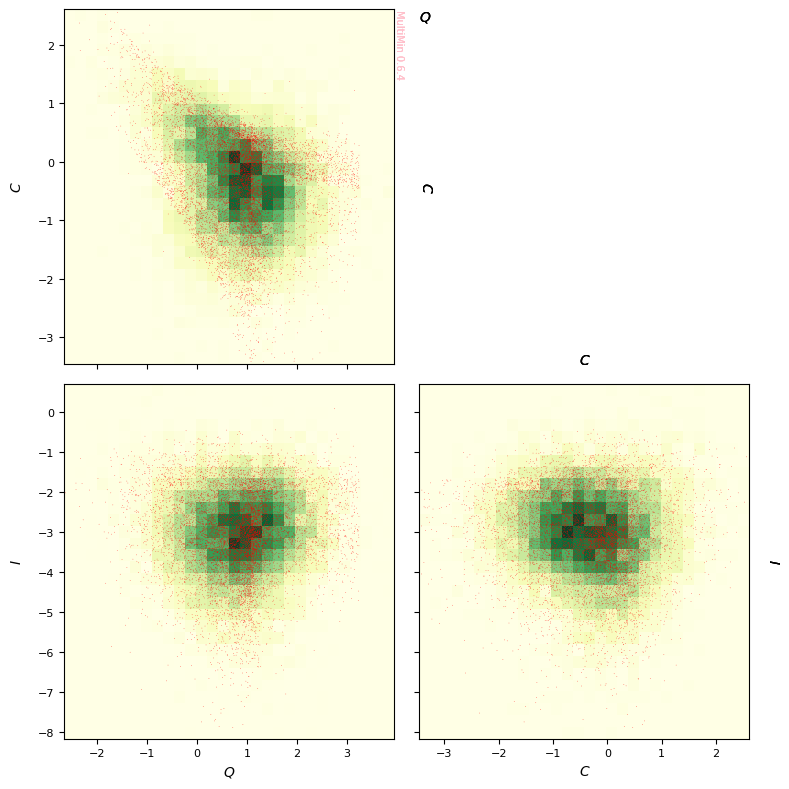

In [35]:
F=mn.FitCMND(ngauss=2,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=5,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.2, 2.2, 2.2, 2.9, 1.4, -2.2, 2.7, -0.038, -2.2, 1.9, 0.29, -2.9, 1.7, 2.6, -1.8, 1.2, 0.87, -2, -0.98, -1.2, -1.4, -1.6, -2.1, -2.5, -2.2, -2.7, -2, -1.4, -0.73, -2.4, -2.4, -1.8, -1.9, 2.1, 1.6, 1.5, 2.3, 1.4, 0.94, 0.78, 1.4, 0.99, 1.4, 1, 1.3, 0.66, 1.3, 1.4]
	LogL/N: 4.825730756748036
Iter 10:
	Vars: [-1.3, 0.15, -0.35, -0.42, 1.2, -0.095, 0.77, -3, 1.6, -0.33, -2.7, 1.1, 0.26, -3.6, -0.003, -0.7, -2.6, 0.92, -0.73, -3.2, -2.8, -2.8, -2.2, -2.4, -3, -2.5, -3.1, -3.6, -2.1, -2.5, -2, -2.3, -3.1, -2.6, -2, -2.9, -0.13, 0.12, -0.0086, 0.022, -0.35, -1.2, 0.3, 0.28, -2.8, -0.18, 0.46, -0.91, 0.7, -0.32]
	LogL/N: 3.721896337820463
Iter 15:
	Vars: [-1.2, 0.5, -0.17, -0.28, 0.82, 0.0036, 0.66, -3, 1.5, -0.31, -2.7, 1.1, 0.27, -3.5, -0.015, -0.72, -2.8, 0.97, -0.76, -3.3, -2.8, -2.8, -2.2, -2.3, -2.8, -2.5, -3, -3.5, -2.2, -2.5, -2, -2.2, -3.2, -2.7, -2, -2.9, -0.11, 0.084, -0.13, -0.051, -0.26, -1.6, 0.23, 0.2, -2.9, -0.2, 0.4, -1, 0.7, -0.57]
	LogL

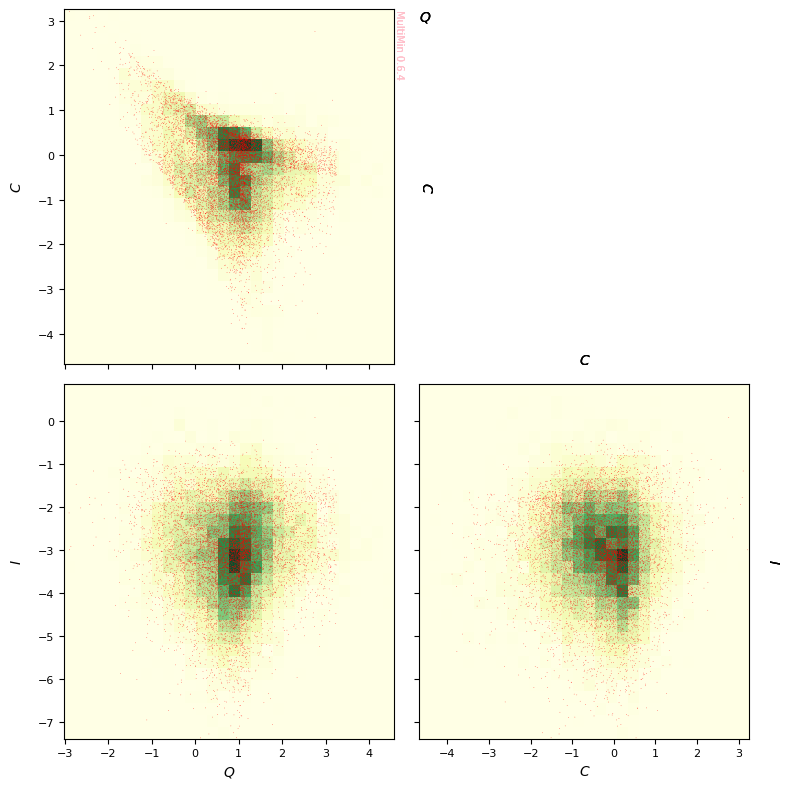

In [36]:
F=mn.FitCMND(ngauss=5,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=10,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted CMND and comparing to the data:

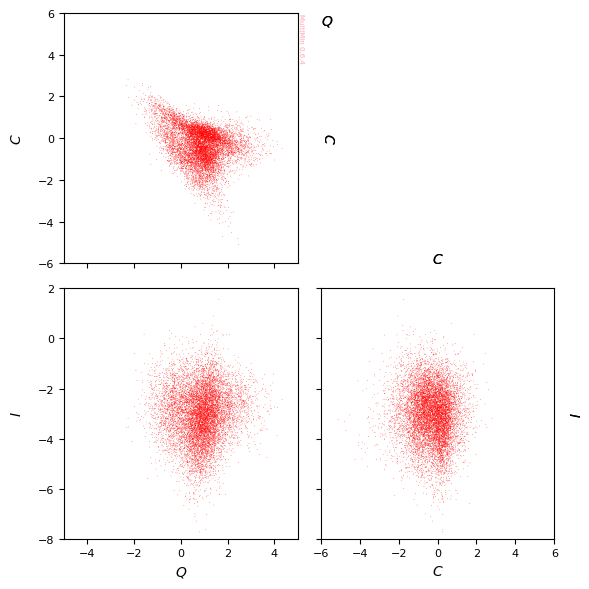

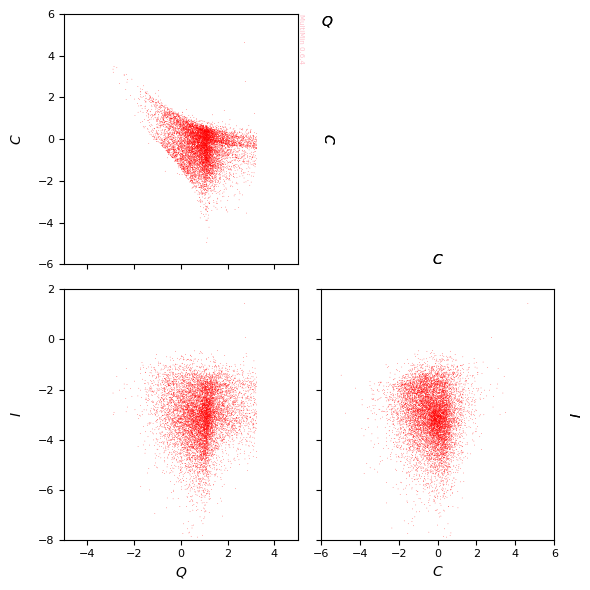

In [37]:
F.cmnd.plot_sample(N=len(F.data),
                  figsize=3,
                  props=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")
properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

In [38]:
function, cmnd = F.cmnd.get_function(properties=properties)

from multimin import nmd

def cmnd(X):

    mu1_Q = 0.003599
    mu1_C = 0.662258
    mu1_I = -3.021546
    mu1 = [mu1_Q, mu1_C, mu1_I]
    Sigma1 = [[0.319329, -0.288119, -0.032769], [-0.288119, 0.325524, 0.024097], [-0.032769, 0.024097, 1.022976]]
    n1 = nmd(X, mu1, Sigma1)

    mu2_Q = 1.502394
    mu2_C = -0.3138
    mu2_I = -2.650327
    mu2 = [mu2_Q, mu2_C, mu2_I]
    Sigma2 = [[0.782756, -0.031233, -0.017529], [-0.031233, 0.300255, -0.0558], [-0.017529, -0.0558, 0.610234]]
    n2 = nmd(X, mu2, Sigma2)

    mu3_Q = 1.069175
    mu3_C = 0.26669
    mu3_I = -3.512875
    mu3 = [mu3_Q, mu3_C, mu3_I]
    Sigma3 = [[0.234554, -0.090867, 0.056971], [-0.090867, 0.078285, 0.027862], [0.056971, 0.027862, 1.046191]]
    n3 = nmd(X, mu3, Sigma3)

    mu4_Q = -0.014608
    mu4_C = -0.715087
    mu4_I = -2.797115
    mu4 = [mu4_Q, mu4_C, mu4_I]
    Sigma4 = [[0.531637, -0.763995, -0.07308], [-0.763995, 1.377778, 0.238481], [-0.07308, 0.238481, 1.03549]]
    n4 = nmd(X, mu4, Sigma4)

    mu5

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga